# Training strategies

In [1]:
import copy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import train_test_split

data: pd.DataFrame = pd.read_csv('datasets/qsar_oral_toxicity_v2.csv')
original_data = copy.deepcopy(data)
target = 'IS_TOXIC'
positive = 'positive'
negative = 'negative'
print(data['IS_TOXIC'].value_counts())
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}
y: np.ndarray = data.pop('IS_TOXIC').values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)

negative    8251
positive     741
Name: IS_TOXIC, dtype: int64


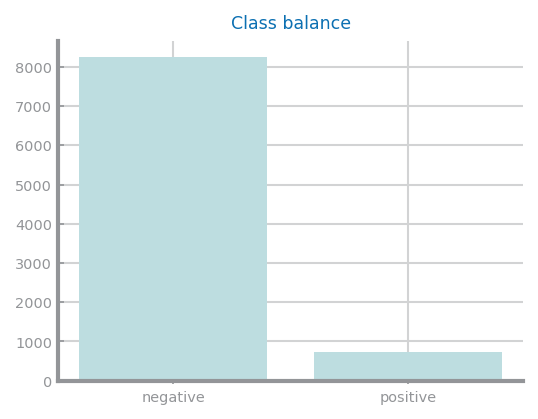

IS_TOXIC = Positive Minority class: 741
IS_TOXIC = Negative Majority class: 8251
Proportion: 0.09 : 1


In [3]:
target_count = original_data['IS_TOXIC'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('IS_TOXIC = Positive Minority class:', target_count[ind_min_class])
print('IS_TOXIC = Negative Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 2), ': 1')

Given the prior proportion, we consider that a Data Balancing Technique is needed.

# Unbalanced Naive Bayes

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.naive_bayes import *
import ds_functions as ds

data: pd.DataFrame = pd.read_csv('datasets/qsar_oral_toxicity_v2.csv')
y: np.ndarray = data.pop('IS_TOXIC').values
X: np.ndarray = data.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

## Multinomial

Confusion Matrix Test
TruePositives:  2163
FalsePositives:  83
TrueNegatives:  139
FalseNegatives:  313


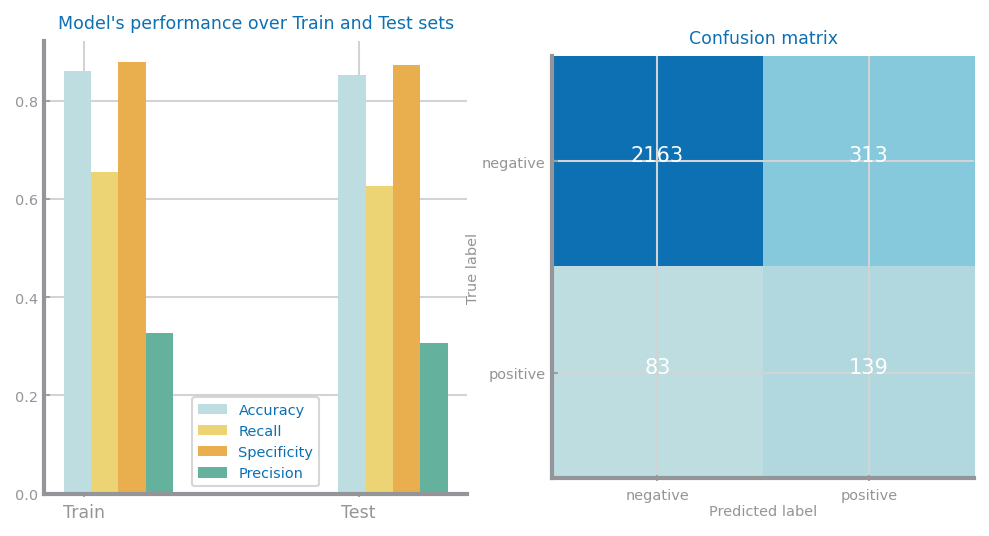

In [6]:
clf = MultinomialNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

## Gaussian

Confusion Matrix Test
TruePositives:  1820
FalsePositives:  65
TrueNegatives:  157
FalseNegatives:  656


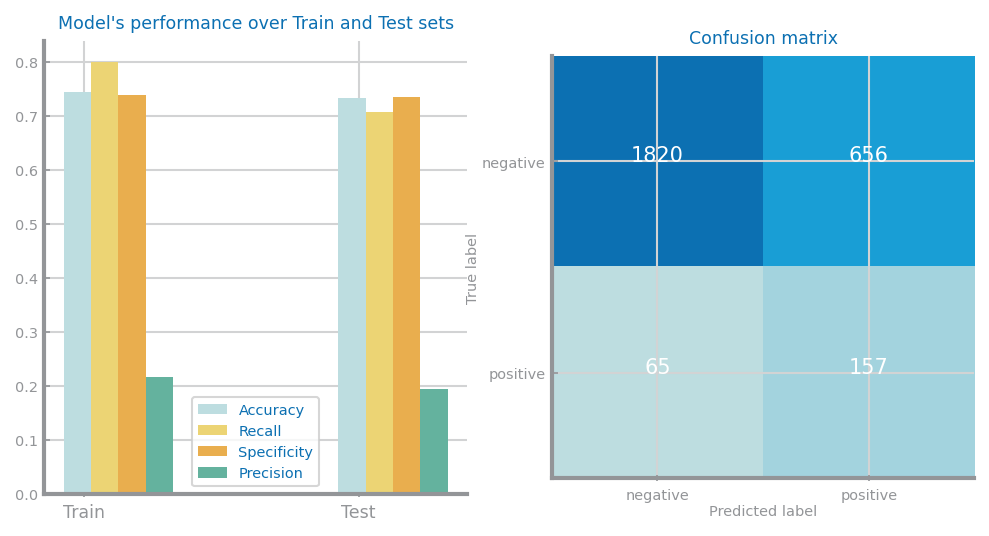

In [8]:
clf = GaussianNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

## Bernoulli

Confusion Matrix Test
TruePositives:  1915
FalsePositives:  78
TrueNegatives:  144
FalseNegatives:  561


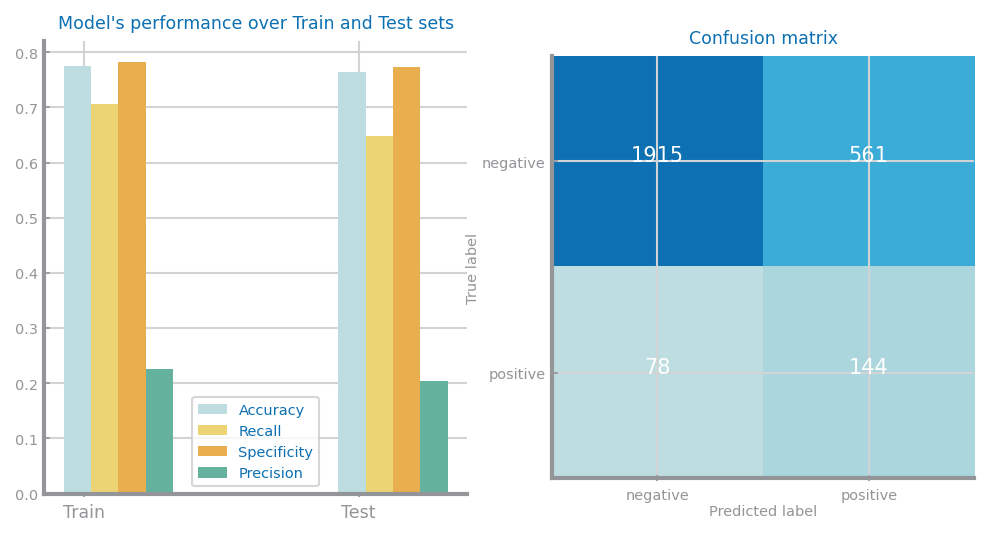

In [9]:
clf = BernoulliNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

## Comparison between models for unbalanced data

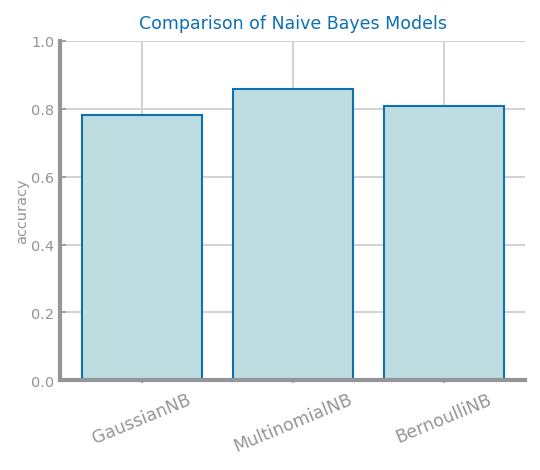

In [95]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()
             }

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.xticks(rotation=22.5)
plt.show()

* GaussianNB: implements the Gaussian Naive Bayes algorithm for classification, wherein the likelihood of the features is assumed to be Gaussian
* MultinomialNB: implements the naive Bayes algorithm for multinomially distributed data, suitable for classification with discrete features
* BernoulyNB: implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions, ie, there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable

Bearing in mind that all attributes are either 0 or 1, hence discrete features, Multinomial model has a higher accuracy.

# Preparing data for balancing

In [83]:
data: pd.DataFrame = pd.read_csv('datasets/qsar_oral_toxicity_v2.csv')
y: np.ndarray = data.pop('IS_TOXIC').values
X: np.ndarray = data.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

print(trnX)
print(trnY)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]
['positive' 'negative' 'negative' ... 'negative' 'negative' 'negative']


In [140]:
def balancing(trnX, trnY, undersample, oversample):
    #undersample, oversample = 1,0 => undersample
    #undersample, oversample = 0,1 => oversample
    unique, counts = np.unique(trnY, return_counts=True)
    
    min_positive_counts = min(counts)
    min_negative_counts = max(counts)+(min(counts)-max(counts))*undersample
    newtrnY: np.ndarray = []
    newtrnX: np.ndarray = []
    for idx in range(len(trnY)):
        if min_positive_counts > 0 and trnY[idx] == 'positive':
            newtrnY.append(trnY[idx])
            newtrnX.append(trnX[idx])
            min_positive_counts -= 1
        elif min_negative_counts > 0 and trnY[idx] == 'negative':
            newtrnY.append(trnY[idx])
            newtrnX.append(trnX[idx])
            min_negative_counts -= 1
            
    unique1, counts1 = np.unique(newtrnY, return_counts=True)
    
    max_positive_counts = min(counts1)+(max(counts1)-min(counts1))*oversample
    max_negative_counts = max(counts1)
    finaltrnY: np.ndarray = []
    finaltrnX: np.ndarray = []
    negX: np.ndarray = []
    posX: np.ndarray = []
    negY: np.ndarray = []
    posY: np.ndarray = []
        
    for idx in range(len(newtrnY)):
        if newtrnY[idx] == 'negative':
            finaltrnY.append(newtrnY[idx])
            negY.append(newtrnY[idx])
            finaltrnX.append(newtrnX[idx])
            negX.append(newtrnX[idx])
            max_negative_counts -= 1
        elif newtrnY[idx] == 'positive':
            finaltrnY.append(newtrnY[idx])
            posY.append(newtrnY[idx])
            finaltrnX.append(newtrnX[idx])
            posX.append(newtrnX[idx])
            max_positive_counts -= 1

    random.seed()

    while max_negative_counts > 0:
        rand_num = random.randint(0,len(negX)-1)
        finaltrnX.append(negX[rand_num])
        finaltrnY.append(negY[rand_num])
        max_negative_counts -= 1

    while max_positive_counts > 0:
        rand_num = random.randint(0,len(posX)-1)
        finaltrnX.append(posX[rand_num])
        finaltrnY.append(posY[rand_num])
        max_positive_counts -= 1
    
    return finaltrnX, finaltrnY
    

# UnderSample Naive Bayes

In [125]:
undertrnX, undertrnY = balancing(trnX,trnY,1,0)

## Multinomial

Confusion Matrix Test
TruePositives:  1922
FalsePositives:  51
TrueNegatives:  171
FalseNegatives:  554


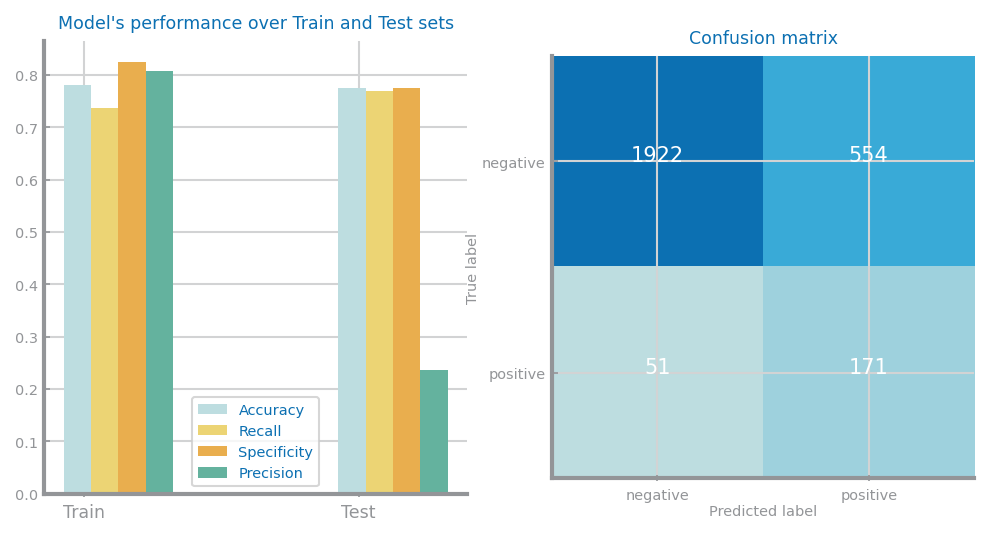

In [126]:
clf = MultinomialNB()
clf.fit(undertrnX, undertrnY)
prd_trn = clf.predict(undertrnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), undertrnY, prd_trn, tstY, prd_tst)

## Gaussian

Confusion Matrix Test
TruePositives:  1990
FalsePositives:  60
TrueNegatives:  162
FalseNegatives:  486


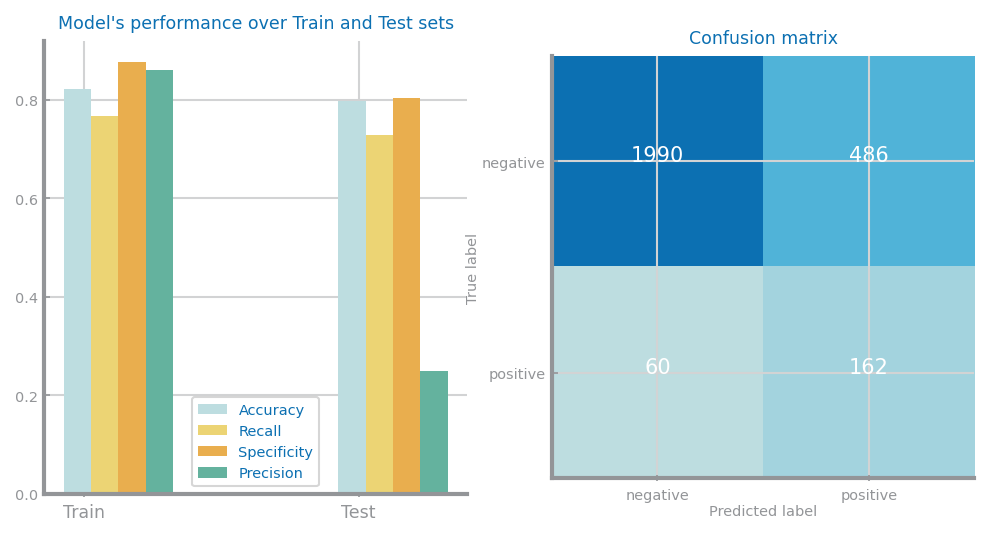

In [127]:
clf = GaussianNB()
clf.fit(undertrnX, undertrnY)
prd_trn = clf.predict(undertrnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), undertrnY, prd_trn, tstY, prd_tst)

## Bernoulli

Confusion Matrix Test
TruePositives:  1790
FalsePositives:  52
TrueNegatives:  170
FalseNegatives:  686


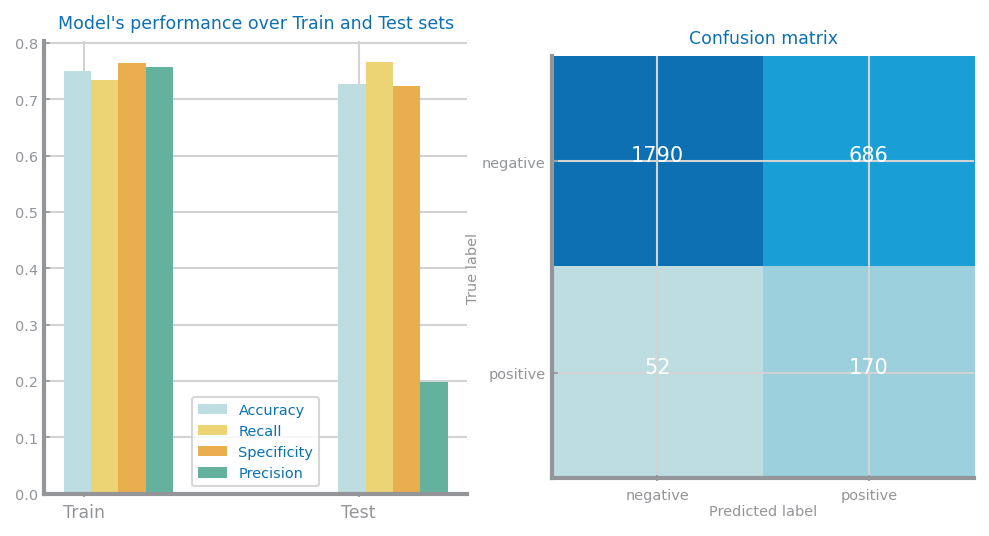

In [128]:
clf = BernoulliNB()
clf.fit(undertrnX, undertrnY)
prd_trn = clf.predict(undertrnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), undertrnY, prd_trn, tstY, prd_tst)

## Comparison between models for UnderSampled data

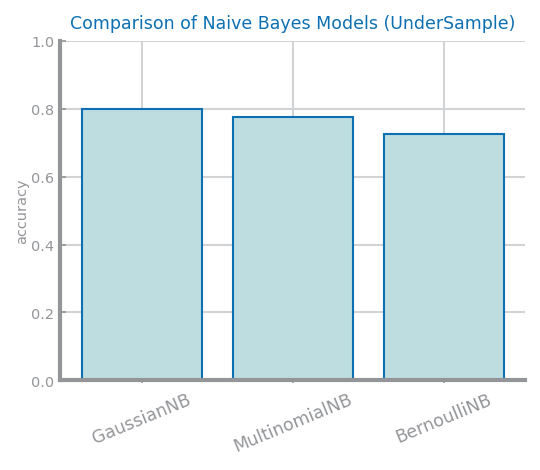

In [129]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()
             }

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(undertrnX, undertrnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models (UnderSample)', ylabel='accuracy', percentage=True)
plt.xticks(rotation=22.5)
plt.show()

# OverSample Naive Bayes

In [131]:
overtrnX, overtrnY = balancing(trnX, trnY, 0, 1)

## Multinomial

Confusion Matrix Test
TruePositives:  1983
FalsePositives:  52
TrueNegatives:  170
FalseNegatives:  493


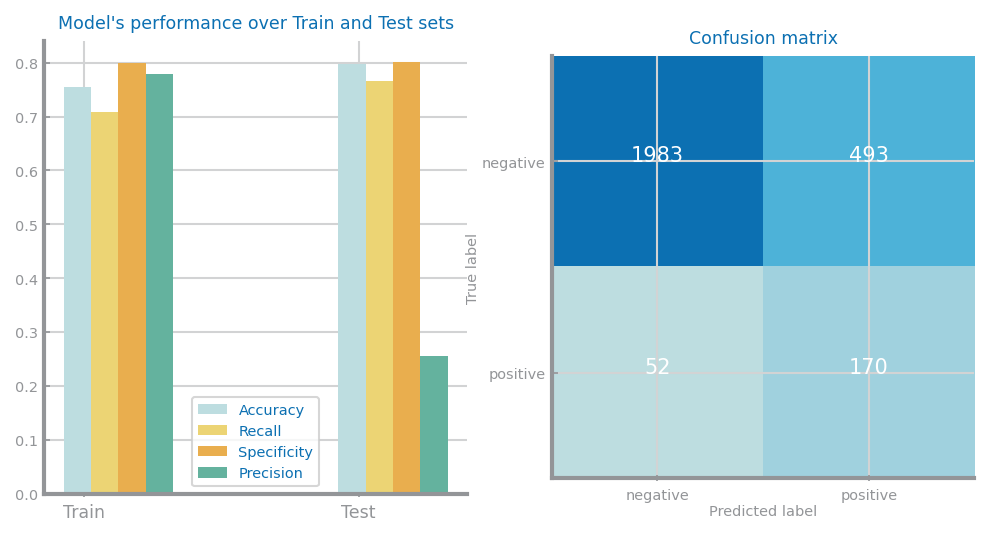

In [132]:
clf = MultinomialNB()
clf.fit(overtrnX, overtrnY)
prd_trn = clf.predict(overtrnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), overtrnY, prd_trn, tstY, prd_tst)

## Gaussian

Confusion Matrix Test
TruePositives:  1928
FalsePositives:  55
TrueNegatives:  167
FalseNegatives:  548


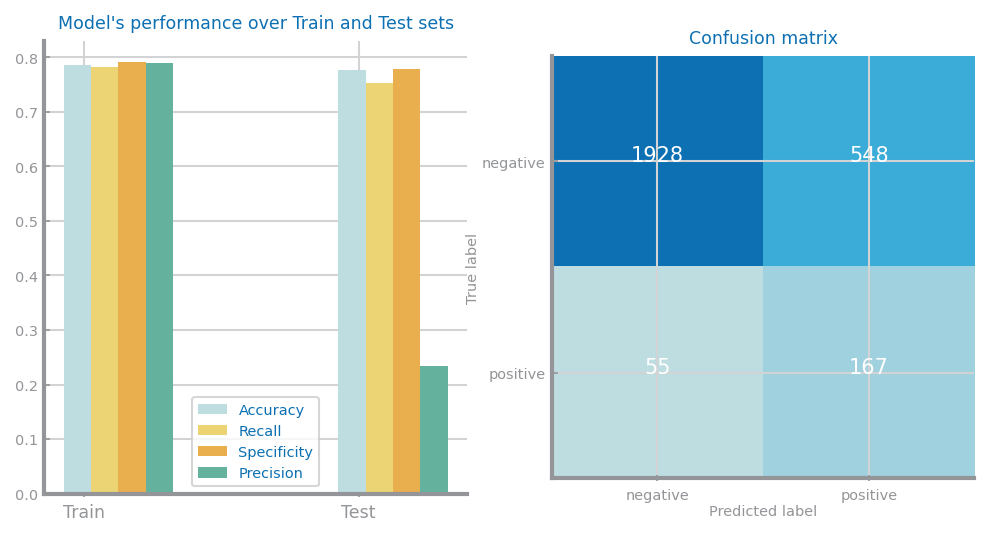

In [133]:
clf = GaussianNB()
clf.fit(overtrnX, overtrnY)
prd_trn = clf.predict(overtrnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), overtrnY, prd_trn, tstY, prd_tst)

## Bernoulli

Confusion Matrix Test
TruePositives:  1796
FalsePositives:  54
TrueNegatives:  168
FalseNegatives:  680


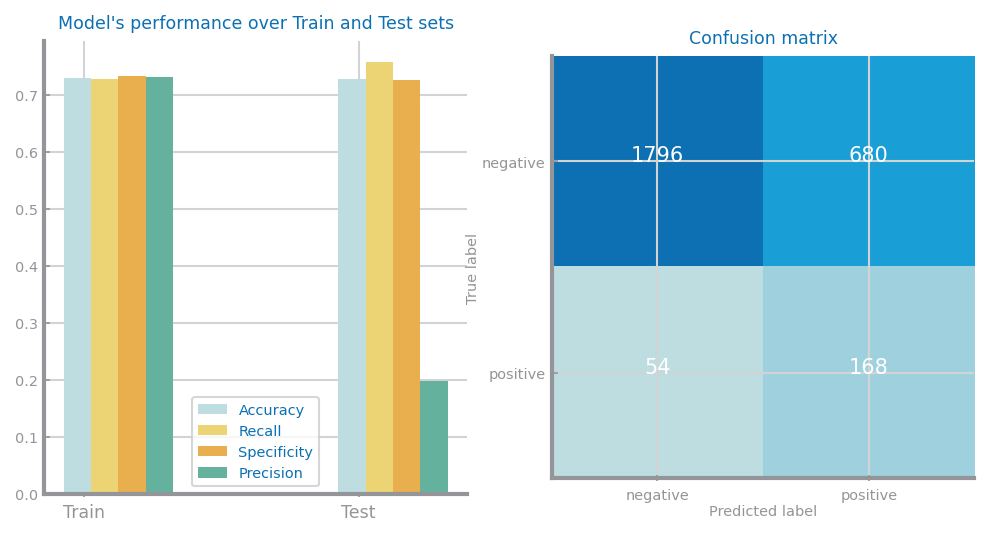

In [134]:
clf = BernoulliNB()
clf.fit(overtrnX, overtrnY)
prd_trn = clf.predict(overtrnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), overtrnY, prd_trn, tstY, prd_tst)

## Comparison between models for OverSampled data

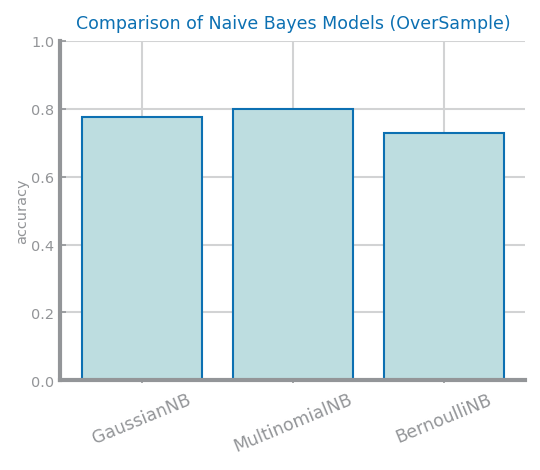

In [135]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()
             }

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(overtrnX, overtrnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models (OverSample)', ylabel='accuracy', percentage=True)
plt.xticks(rotation=22.5)
plt.show()

# SMOTE Naive Bayes

In [117]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
smote_X, smote_y = smote.fit_sample(trnX, trnY)

11550


## Multinomial

Confusion Matrix Test
TruePositives:  2172
FalsePositives:  92
TrueNegatives:  130
FalseNegatives:  304


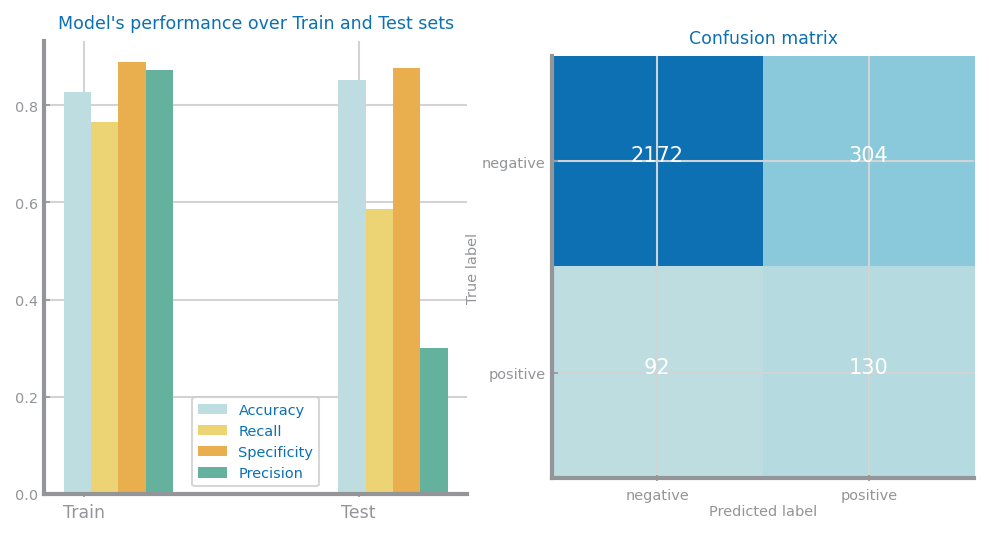

In [118]:
clf = MultinomialNB()
clf.fit(smote_X, smote_y)
prd_trn = clf.predict(smote_X)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), smote_y, prd_trn, tstY, prd_tst)

## Gaussian

Confusion Matrix Test
TruePositives:  2085
FalsePositives:  136
TrueNegatives:  86
FalseNegatives:  391


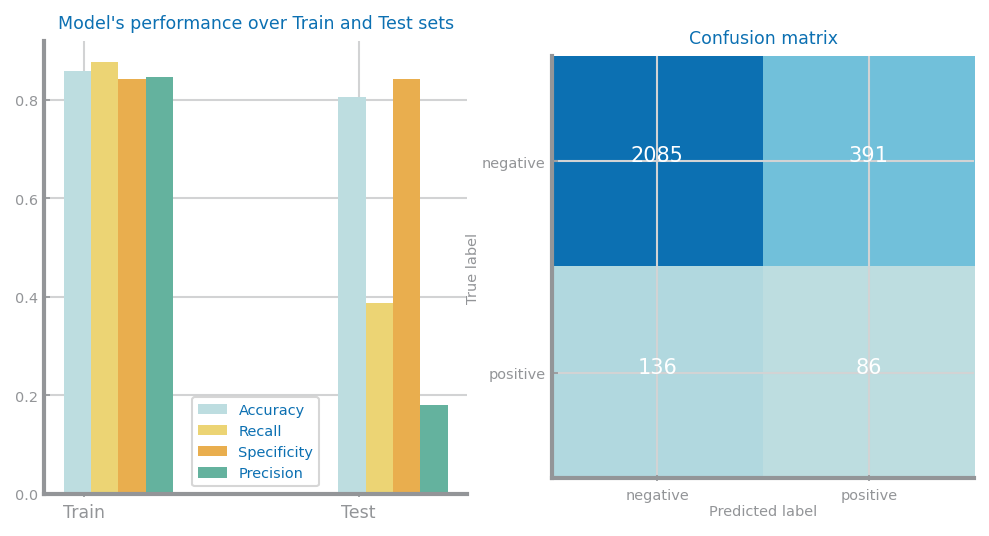

In [119]:
clf = GaussianNB()
clf.fit(smote_X, smote_y)
prd_trn = clf.predict(smote_X)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), smote_y, prd_trn, tstY, prd_tst)

## Bernoulli

Confusion Matrix Test
TruePositives:  1738
FalsePositives:  80
TrueNegatives:  142
FalseNegatives:  738


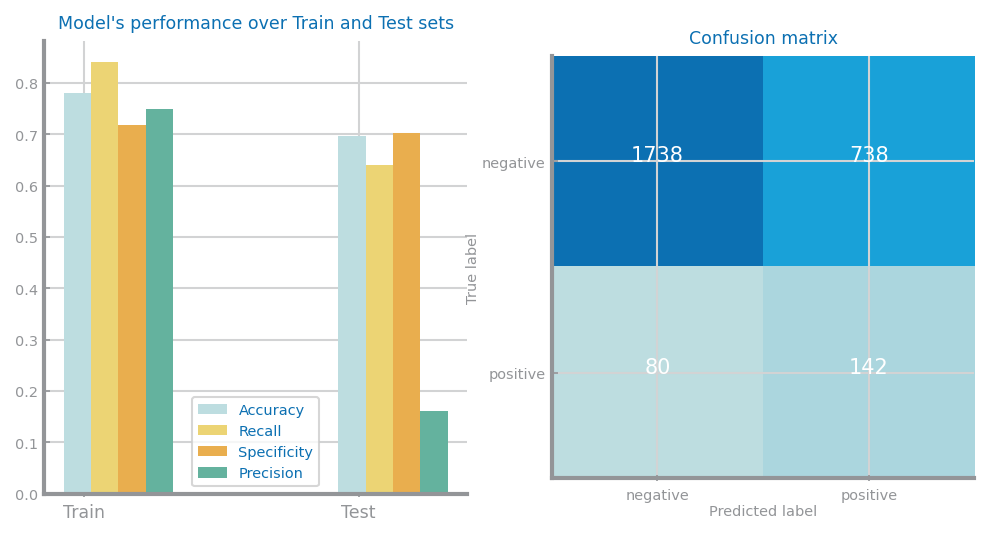

In [120]:
clf = BernoulliNB()
clf.fit(smote_X, smote_y)
prd_trn = clf.predict(smote_X)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), smote_y, prd_trn, tstY, prd_tst)

## Comparison between models for SMOTE data

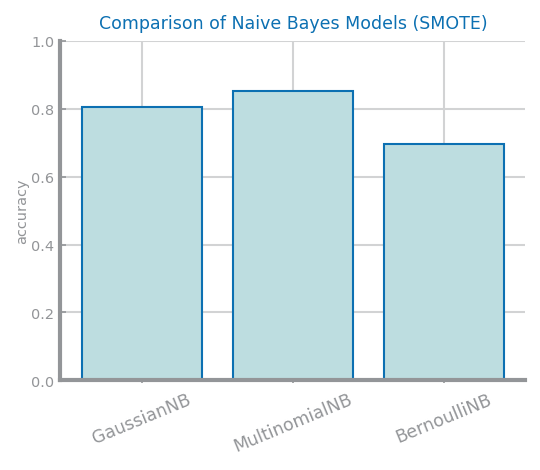

In [121]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()
             }

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(smote_X, smote_y)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models (SMOTE)', ylabel='accuracy', percentage=True)
plt.xticks(rotation=22.5)
plt.show()

# Combining OverSample and UnderSample to find the best F2-Score

## Multinomial

0.7000000000000001 0.2
Confusion Matrix Test
TruePositives:  2075
FalsePositives:  58
TrueNegatives:  164
FalseNegatives:  401


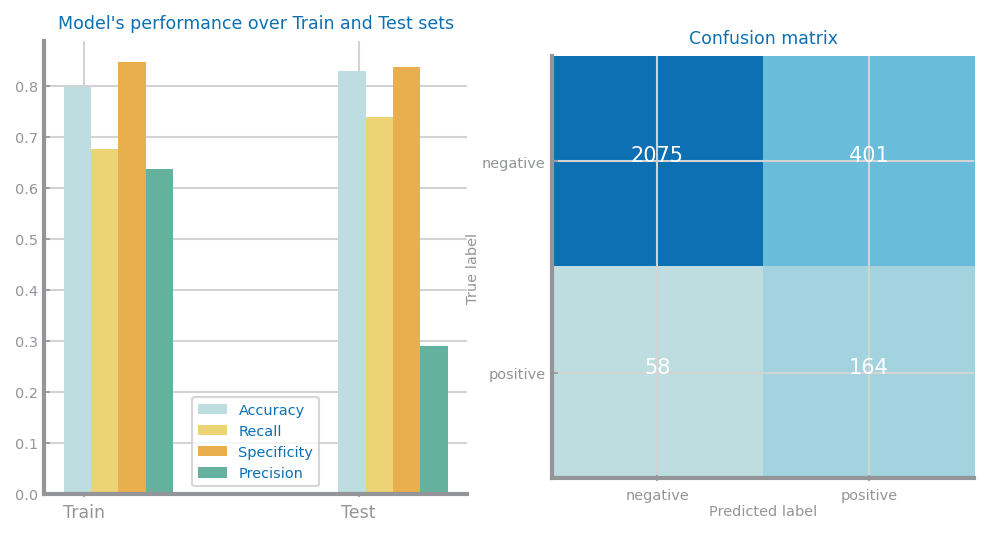

In [149]:
undersample_range = [x*0.1 for x in range(11)]
oversample_range = [x*0.1 for x in range(11)]
best_f2score = 0
under_fact = 0
over_fact = 0
for undersample in undersample_range:
    for oversample in oversample_range:
        clf = MultinomialNB()
        mnX, mnY = balancing(trnX,trnY,undersample,oversample)
        clf.fit(mnX, mnY)
        prd_trn = clf.predict(mnX)
        prd_tst = clf.predict(tstX)
        cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
        tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
        current_f2score =  5 * tp_tst / (5 * tp_tst + 4 * fn_tst + fp_tst)
        if current_f2score > best_f2score:
            under_fact = undersample
            over_fact = oversample
            best_f2score = current_f2score
            bestY = mnY
            best_prd_tst = prd_tst
            best_prd_trn = prd_trn
print(under_fact, over_fact)
ds.plot_evaluation_results(pd.unique(y), bestY, best_prd_trn, tstY, best_prd_tst)

## Gaussian

0.8 0.5
Confusion Matrix Test
TruePositives:  2040
FalsePositives:  62
TrueNegatives:  160
FalseNegatives:  436


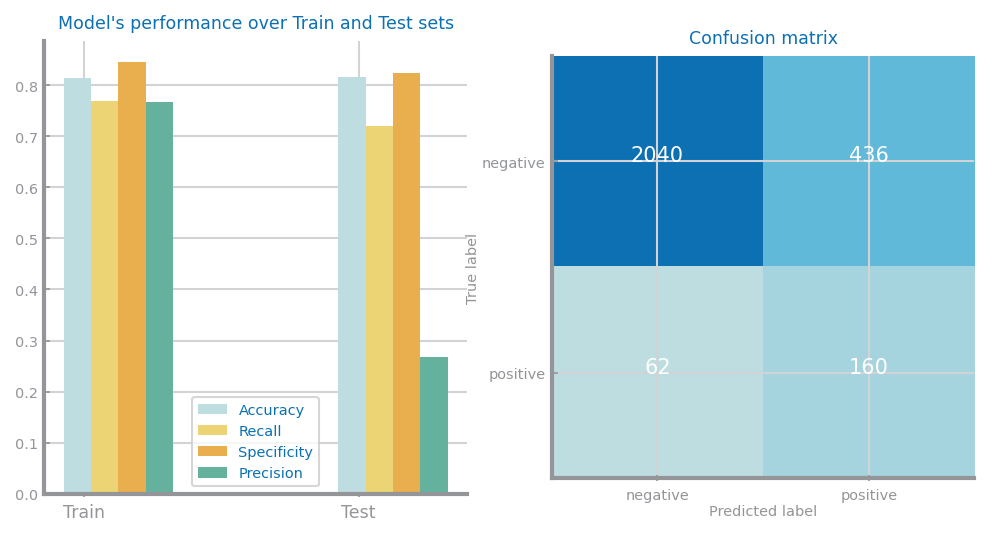

In [150]:
undersample_range = [x*0.1 for x in range(11)]
oversample_range = [x*0.1 for x in range(11)]
best_f2score = 0
under_fact = 0
over_fact = 0
for undersample in undersample_range:
    for oversample in oversample_range:
        clf = GaussianNB()
        mnX, mnY = balancing(trnX,trnY,undersample,oversample)
        clf.fit(mnX, mnY)
        prd_trn = clf.predict(mnX)
        prd_tst = clf.predict(tstX)
        cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
        tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
        current_f2score =  5 * tp_tst / (5 * tp_tst + 4 * fn_tst + fp_tst)
        if current_f2score > best_f2score:
            under_fact = undersample
            over_fact = oversample
            best_f2score = current_f2score
            bestY = mnY
            best_prd_tst = prd_tst
            best_prd_trn = prd_trn
print(under_fact, over_fact)
ds.plot_evaluation_results(pd.unique(y), bestY, best_prd_trn, tstY, best_prd_tst)

## Bernoulli

0.8 0.5
Confusion Matrix Test
TruePositives:  1998
FalsePositives:  55
TrueNegatives:  167
FalseNegatives:  478


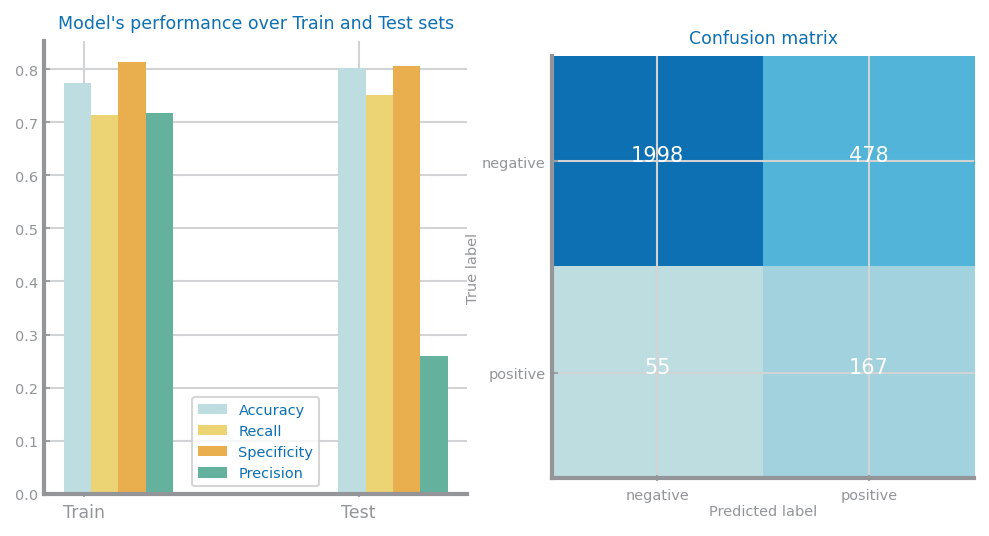

In [151]:
undersample_range = [x*0.1 for x in range(11)]
oversample_range = [x*0.1 for x in range(11)]
best_f2score = 0
under_fact = 0
over_fact = 0
for undersample in undersample_range:
    for oversample in oversample_range:
        clf = BernoulliNB()
        mnX, mnY = balancing(trnX,trnY,undersample,oversample)
        clf.fit(mnX, mnY)
        prd_trn = clf.predict(mnX)
        prd_tst = clf.predict(tstX)
        cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
        tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
        current_f2score =  5 * tp_tst / (5 * tp_tst + 4 * fn_tst + fp_tst)
        if current_f2score > best_f2score:
            under_fact = undersample
            over_fact = oversample
            best_f2score = current_f2score
            bestY = mnY
            best_prd_tst = prd_tst
            best_prd_trn = prd_trn
print(under_fact, over_fact)
ds.plot_evaluation_results(pd.unique(y), bestY, best_prd_trn, tstY, best_prd_tst)

## Comparison between models in our search for best F2_score

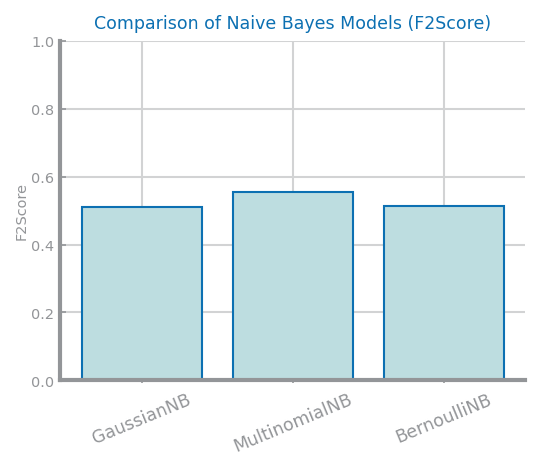

In [155]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()
             }

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    if clf == 'GaussianNB' or clf == 'BernoulliNB':
        valX, valY = balancing(trnX,trnY,0.8,0.5)
    else:
        valX, valY = balancing(trnX,trnY,0.7,0.2)
    estimators[clf].fit(valX, valY)
    prdY = estimators[clf].predict(tstX)
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prdY, labels)
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    yvalues.append( 5 * tp_tst / (5 * tp_tst + 4 * fn_tst + fp_tst))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models (F2Score)', ylabel='F2Score', percentage=True)
plt.xticks(rotation=22.5)
plt.show()

# KNN

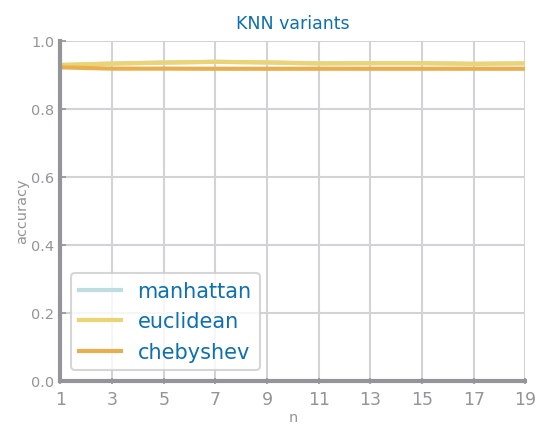

Best results with 7 neighbors and manhattan


In [13]:
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier

labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

Confusion Matrix Test
TruePositives:  2441
FalsePositives:  132
TrueNegatives:  90
FalseNegatives:  35


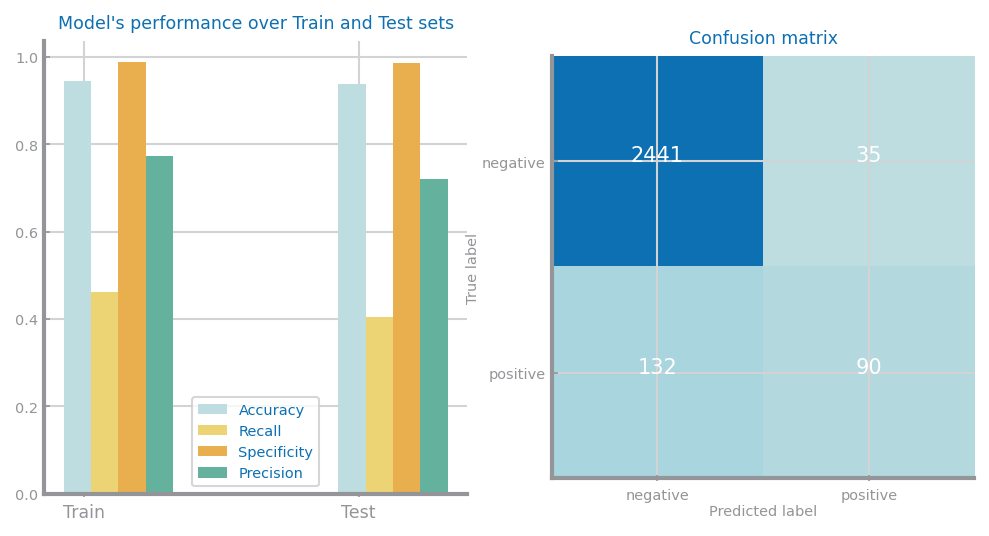

In [14]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)